In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import re
import numpy as np
import requests
import os
import seaborn as sns
tqdm.pandas()
%load_ext google.cloud.bigquery

In [8]:
import pickle
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [9]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [10]:
em = pd.read_excel('data/2209201114_DA_GHGI_1990-2020_Final_v4.1_AR4_AR5.xlsm', sheet_name='UK By Source_AR5', header=16, usecols='B:AC')
em['NCFormat'] = em.NCFormat.fillna(method='ffill')
em = em.melt(id_vars=['NCFormat', 'IPCC_name'])
em = em[em.variable != 'BaseYear']
em['variable']=em['variable'].apply(pd.to_datetime)

In [11]:
em[em.variable == em.variable.max()].NCFormat.unique()

array(['Agriculture', 'Agriculture Total', 'Business', 'Business Total',
       'Energy Supply', 'Energy Supply Total', 'Industrial processes',
       'Industrial processes Total',
       'Land use, land use change and forestry',
       'Land use, land use change and forestry Total', 'Public',
       'Public Total', 'Residential', 'Residential Total', 'Transport',
       'Transport Total', 'Waste Management', 'Waste Management Total',
       'Grand Total'], dtype=object)

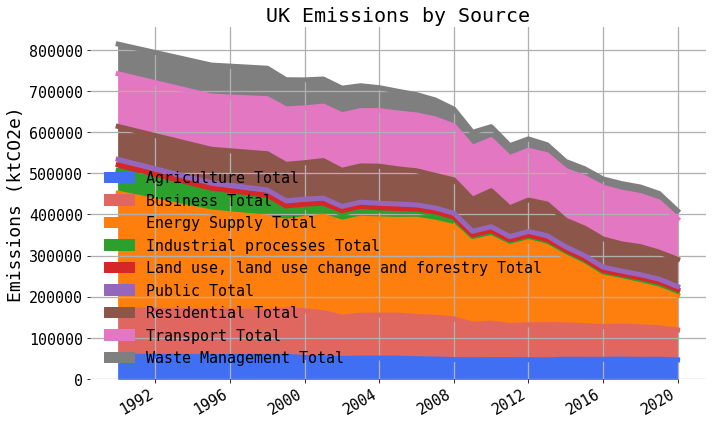

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

em[em.NCFormat.str.contains('Total')].pivot(index='variable', columns='NCFormat', values='value')[
    ['Agriculture Total', 'Business Total', 'Energy Supply Total',
    'Industrial processes Total',
       'Land use, land use change and forestry Total', 'Public Total',
       'Residential Total', 'Transport Total', 'Waste Management Total']
].plot(kind='area', ax=ax)

ax.legend(loc='lower left')
ax.set_title('UK Emissions by Source')
ax.set_ylabel('Emissions (ktCO2e)')
ax.set_xlabel('')

plt.show()

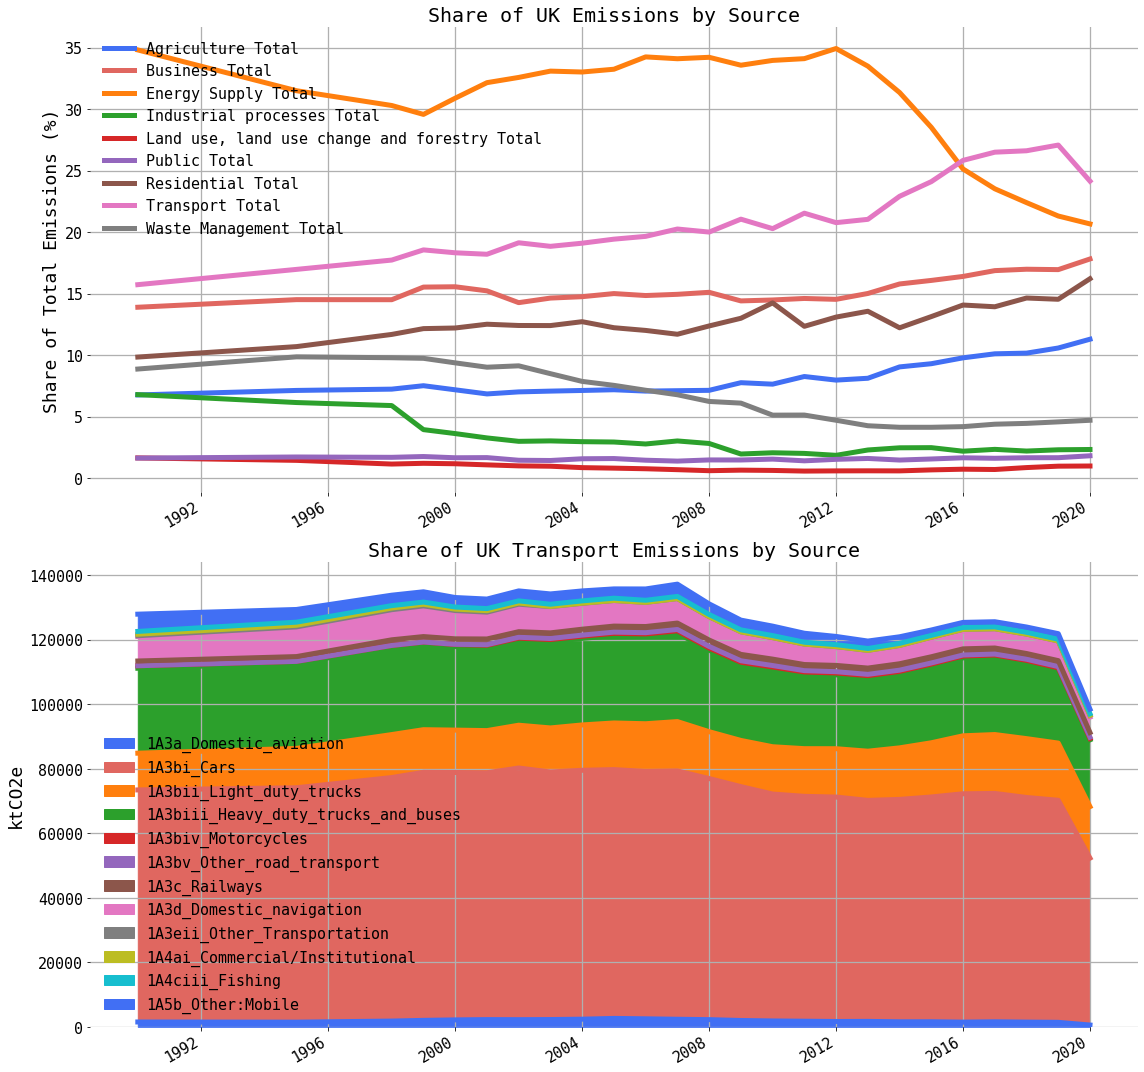

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(16, 15))

em_sel = em[em.NCFormat.str.contains('Total')].pivot(index='variable', columns='NCFormat', values='value')[
    ['Agriculture Total', 'Business Total', 'Energy Supply Total',
    'Industrial processes Total',
       'Land use, land use change and forestry Total', 'Public Total',
       'Residential Total', 'Transport Total', 'Waste Management Total']
]

(100*(em_sel.div(em_sel.sum(axis=1), axis=0))).plot(ax=ax[0])

ax[0].legend(loc='upper left')
ax[0].set_title('Share of UK Emissions by Source')
ax[0].set_ylabel('Share of Total Emissions (%)')
ax[0].set_xlabel('')


em[(em.NCFormat == 'Transport')].pivot(index='variable', columns='IPCC_name', values='value').iloc[:, :12].plot(kind='area', ax=ax[1])

ax[1].legend(loc='lower left')
ax[1].set_title('Share of UK Transport Emissions by Source')
ax[1].set_ylabel('ktCO2e')
ax[1].set_xlabel('')

plt.savefig('plots/emissions_by_source.png', transparent=False, bbox_inches='tight', dpi=300)

plt.show()

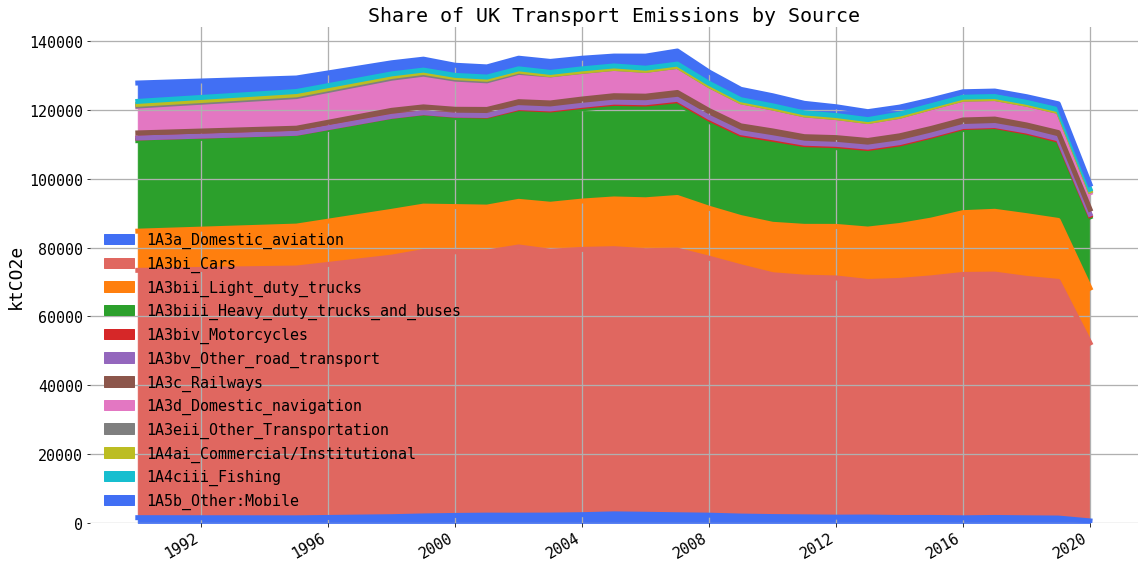

In [28]:
fig, ax = plt.subplots(figsize=(16, 8))

em[(em.NCFormat == 'Transport')].pivot(index='variable', columns='IPCC_name', values='value').iloc[:, :12].plot(kind='area', ax=ax)

ax.legend(loc='lower left')
ax.set_title('Share of UK Transport Emissions by Source')
ax.set_ylabel('ktCO2e')
ax.set_xlabel('')

plt.savefig('plots/transport_emissions_by_source.png', transparent=False, bbox_inches='tight', dpi=300)

plt.show()

In [29]:
category = '1A3bi_Cars'
em_c_tot = em[em.NCFormat=='Grand Total'].pivot(index='variable', values='value', columns='NCFormat').merge(em[em.IPCC_name == category].pivot(index='variable', values='value', columns='IPCC_name'), how='left', left_index=True, right_index=True)
em_c_tot['share'] = em_c_tot.apply(lambda row: 100*row[category] / row['Grand Total'], axis=1)

<AxesSubplot:xlabel='variable'>

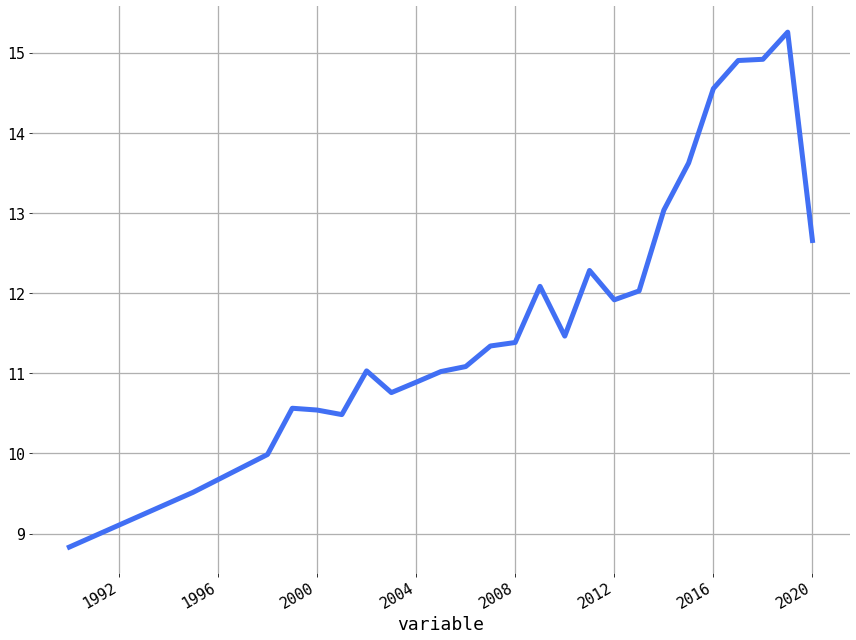

In [30]:
em_c_tot.share.plot()

In [31]:
em[(em.variable == '2019-01-01') & (em.IPCC_name.notna())].sort_values('value', ascending=False).head(10)

,NCFormat,IPCC_name,variable,value
5300,Transport,1A3bi_Cars,2019-01-01,68830.376944
5289,Residential,1A4bi_Residential_stationary,2019-01-01,63760.852944
5200,Energy Supply,1A1ai_Public_Electricity&Heat_Production,2019-01-01,58444.412040
5302,Transport,1A3biii_Heavy_duty_trucks_and_buses,2019-01-01,22766.620694
5171,Business,1A2gviii_Other_manufacturing_industries_and_co...,2019-01-01,20728.613919
5301,Transport,1A3bii_Light_duty_trucks,2019-01-01,17726.964900
5314,Waste Management,5A1a_Managed_Waste_Disposal_sites_anaerobic,2019-01-01,15692.341525
5204,Energy Supply,1A1cii_Oil_and_gas_extraction,2019-01-01,12968.384934
5202,Energy Supply,1A1b_Petroleum_Refining,2019-01-01,12647.428817
5116,Agriculture,3A1b_Enteric_Fermentation_non-dairy_cattle,2019-01-01,11816.864067


In [50]:
%%bigquery eccm1 --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, COUNT(*) as total
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND monthOfFirstRegistration > '2010-01-01'
AND monthOfFirstRegistration < '2023-05-01'
AND fuelType IS NOT NULL
GROUP BY monthOfFirstRegistration, fuelType

Downloading: 100%|██████████| 996/996 [00:01<00:00, 975.17rows/s]


In [51]:
eccm1['fuelType'] = eccm1.fuelType.apply(ft_cleaner)
eccm1 = eccm1.groupby(['monthOfFirstRegistration', 'fuelType']).sum().reset_index('fuelType').pivot(columns='fuelType', values='total')
eccm1r = eccm1.rolling(12).sum()/1000000


In [64]:
eccm1r.div(eccm1r.sum(axis=1), axis=0).tail(1)[['Petrol', 'Diesel', 'Hybrid']].sum(axis=1)

monthOfFirstRegistration
2023-04-01 00:00:00+00:00    0.827444
dtype: float64

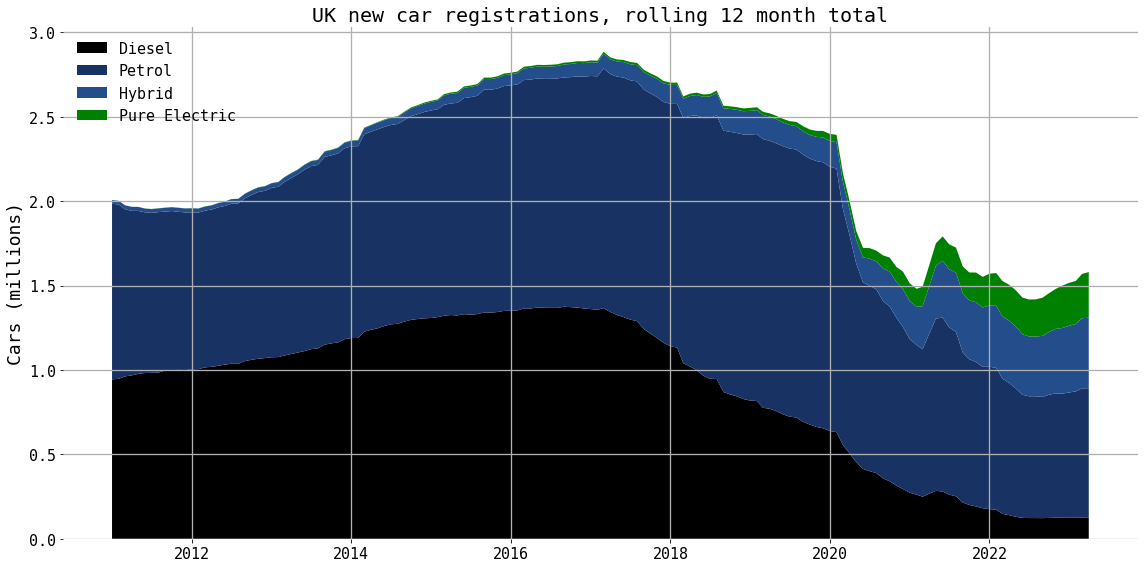

In [53]:

fig, ax = plt.subplots(figsize=(16, 8))

# ax.plot(eccm1r.Diesel, c='black', label='Diesel')
# ax.plot(eccm1r.Petrol, c='#183363', label='Petrol')
# ax.plot(eccm1r['Pure Electric'], c='green', label='Pure Electric')
# ax.plot(eccm1r['Hybrid'], c='#244d8c', label='Hybrid')


ax.stackplot(eccm1r.index, eccm1r.Diesel, eccm1r.Petrol, eccm1r.Hybrid, eccm1r['Pure Electric'], 
             colors=['black', '#183363', '#244d8c', 'green'],
            labels=['Diesel', 'Petrol', 'Hybrid', 'Pure Electric'])

ax.set_title('UK new car registrations, rolling 12 month total')
ax.legend(loc='upper left')
ax.set_ylabel('Cars (millions)')

plt.savefig('plots/market_new_cars_12months.png', transparent=False, bbox_inches='tight', dpi=300)

plt.show()

In [55]:
%%bigquery eccn1 --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, COUNT(*) as total
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'N1'
AND monthOfFirstRegistration > '2010-01-01'
AND monthOfFirstRegistration < '2023-05-01'
AND fuelType IS NOT NULL
GROUP BY monthOfFirstRegistration, fuelType

Downloading: 100%|██████████| 699/699 [00:00<00:00, 778.47rows/s] 


In [56]:
eccn1['fuelType'] = eccn1.fuelType.apply(ft_cleaner)
eccn1 = eccn1.groupby(['monthOfFirstRegistration', 'fuelType']).sum().reset_index('fuelType').pivot(columns='fuelType', values='total')
eccn1r = eccn1.rolling(12).sum()



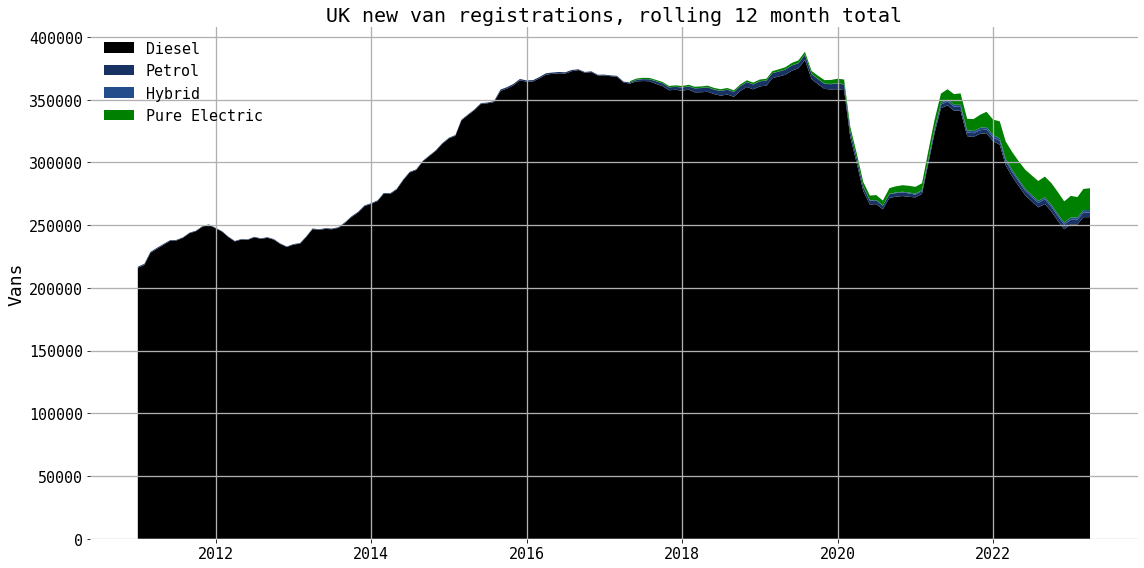

In [60]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.stackplot(eccn1r.index, eccn1r.Diesel, eccn1r.Petrol, eccn1r.Hybrid, eccn1r['Pure Electric'], 
             colors=['black', '#183363', '#244d8c', 'green'],
            labels=['Diesel', 'Petrol', 'Hybrid', 'Pure Electric'])

ax.set_title('UK new van registrations, rolling 12 month total')
ax.legend(loc='upper left')
ax.set_ylabel('Vans')

plt.savefig('plots/market_new_vans_12months.png', transparent=False, bbox_inches='tight', dpi=300)


plt.show()

In [61]:
eccn1r.div(eccn1r.sum(axis=1), axis=0).tail(1)

fuelType,Diesel,Hybrid,Other,Petrol,Pure Electric
monthOfFirstRegistration,,,,,
2023-04-01 00:00:00+00:00,0.917476,0.007318,NaN,0.013086,0.06212
